<img width="800px" src="../fidle/img/00-Fidle-header-01.svg"></img>

# <!-- TITLE --> [SYNOP3] - 12h predictions
<!-- DESC --> Episode 3: Attempt to predict in a more longer term 
<!-- AUTHOR : Jean-Luc Parouty (CNRS/SIMaP) -->

## Objectives :
 - Prediction at 12:00
 - Understand the principle of using recurrent neurons... and the limitations of our example !


SYNOP meteorological data, available at: https://public.opendatasoft.com

## What we're going to do :

 - Read the data
 - Make a reccurent prediction

## Step 1 - Import and init
### 1.1 - Python

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

import numpy as np
import math, random
import matplotlib.pyplot as plt

import pandas as pd
import h5py, json
import os,time,sys

from importlib import reload

sys.path.append('..')
import fidle.pwk as pwk

datasets_dir = pwk.init('SYNOP3')

<br>**FIDLE 2020 - Practical Work Module**

Version              : 2.0.17
Notebook id          : SYNOP3
Run time             : Monday 01 March 2021, 20:32:29
TensorFlow version   : 2.4.0
Keras version        : 2.4.0
Datasets dir         : /gpfswork/rech/mlh/uja62cb/datasets
Run dir              : ./run
Update keras cache   : False
Save figs            : True
Path figs            : ./run/figs


### 1.2 - Parameters

In [2]:
# ---- About dataset
#
dataset_dir      = './data'
dataset_filename = 'synop-LYS.csv'
schema_filename  = 'synop.json'
features         = ['tend', 'cod_tend', 'dd', 'ff', 'td', 'u', 'ww', 'pres', 'rafper', 'rr1', 'rr3', 'tc']
features_len     = len(features)

# ---- About training
#
iterations       = 4        # number of iterations for prediction (1 iteration = 3h)

scale            = 1        # Percentage of dataset to be used (1=all)
train_prop       = .8       # Percentage for train (the rest being for the test)
sequence_len     = 16
batch_size       = 32
epochs           = 10

Override parameters (batch mode) - Just forget this cell

In [3]:
pwk.override('iterations', 'scale', 'train_prop', 'sequence_len', 'batch_size', 'epochs')

**\*\* Overrided parameters : \*\***

iterations           : 4
scale                : 1
train_prop           : 0.8
sequence_len         : 16
batch_size           : 32
epochs               : 10


## Step 2 - Read and prepare dataset
As before, in episode 2... ;-)

In [4]:
# ---- Read dataset

df = pd.read_csv(f'{dataset_dir}/{dataset_filename}', header=0, sep=';')

# ---- Scaling

df = df[:int(scale*len(df))]
train_len=int(train_prop*len(df))

# ---- Train / Test
dataset_train = df.loc[ :train_len-1, features ]
dataset_test  = df.loc[train_len:,    features ]

# ---- Normalize, and convert to numpy array
mean = dataset_train.mean()
std  = dataset_train.std()
dataset_train = np.array( (dataset_train - mean) / std )
dataset_test  = np.array( (dataset_test  - mean) / std )

print('Dataset       : ',df.shape)
print('Train dataset : ',dataset_train.shape)
print('Test  dataset : ',dataset_test.shape)


Dataset       :  (29165, 14)
Train dataset :  (23332, 12)
Test  dataset :  (5833, 12)


## Step 3 - Predict

### 3.1 - Load model

In [5]:
loaded_model = tf.keras.models.load_model('./run/models/best_model.h5')

### 3.2 Make a 12h prediction
Note : Our predictions are normalized

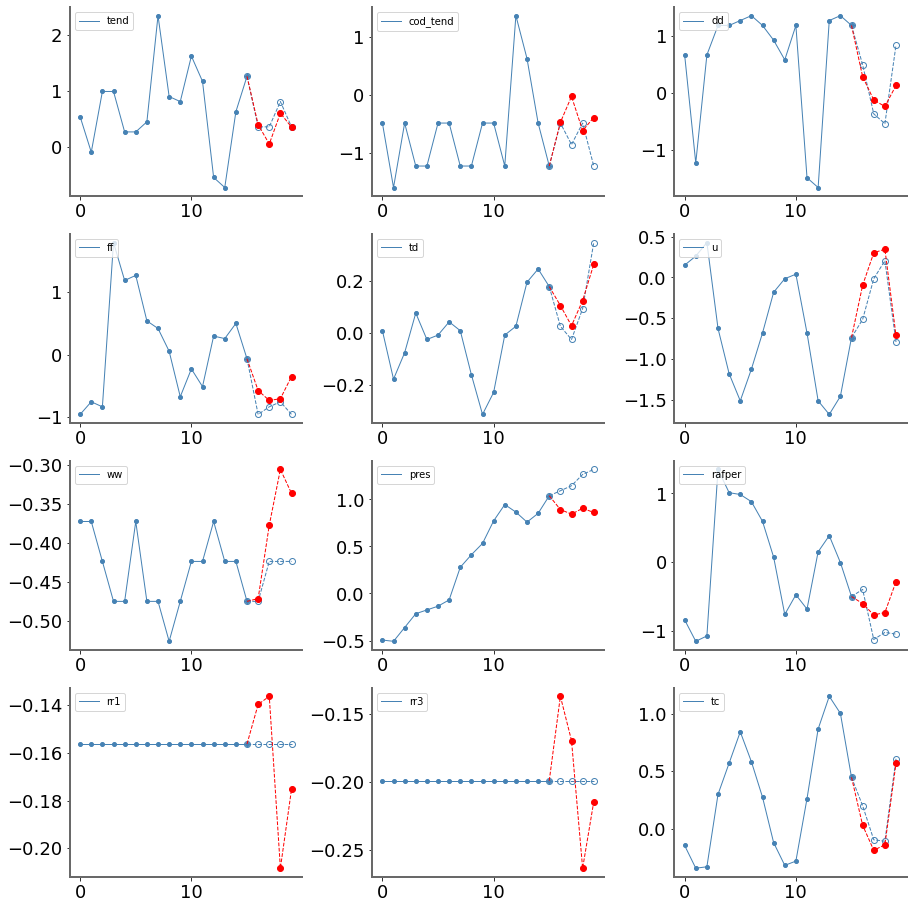

In [6]:

# ---- Initial sequence

s=random.randint(0,len(dataset_test)-sequence_len-iterations)

sequence_pred = dataset_test[s:s+sequence_len].copy()
sequence_true = dataset_test[s:s+sequence_len+iterations].copy()

# ---- Iterate on 4 predictions

sequence_pred=list(sequence_pred)

for i in range(iterations):
    sequence=sequence_pred[-sequence_len:]
    pred = loaded_model.predict( np.array([sequence]) )
    sequence_pred.append(pred[0])

# ---- Extract the predictions    

pred=np.array(sequence_pred[-iterations:])
       
# ---- Show result

pwk.plot_multivariate_serie(sequence_true, predictions=pred, labels=features, save_as='01-prediction-norm')


### 3.3 Full prediction
#### Some cool functions that do the job

In [7]:
def denormalize(mean,std,seq):
    nseq = seq.copy()
    for i,s in enumerate(nseq):
        s = s*std + mean
        nseq[i]=s
    return nseq


def get_prediction(dataset, model, iterations=4,sequence_len=16):

    # ---- Initial sequence

    s=random.randint(0,len(dataset)-sequence_len-iterations)

    sequence_pred = dataset[s:s+sequence_len].copy()
    sequence_true = dataset[s:s+sequence_len+iterations].copy()

    # ---- Iterate

    sequence_pred=list(sequence_pred)

    for i in range(iterations):
        sequence=sequence_pred[-sequence_len:]
        pred = model.predict( np.array([sequence]) )
        sequence_pred.append(pred[0])

    # ---- Extract the predictions    

    pred=np.array(sequence_pred[-iterations:])

    # ---- De-normalization

    sequence_true = denormalize(mean,std, sequence_true)
    pred          = denormalize(mean,std, pred)

    return sequence_true,pred

#### And the result is...

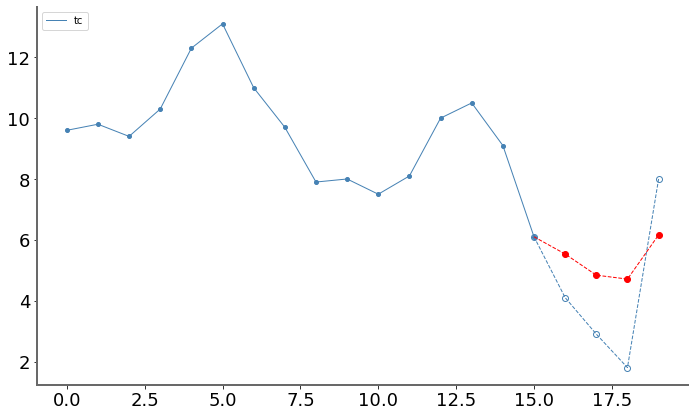

In [8]:
  
sequence_true, pred = get_prediction(dataset_test, loaded_model,iterations=4)

feat=11

pwk.plot_multivariate_serie(sequence_true, predictions=pred, labels=features, only_features=[feat],width=14, height=8, save_as='02-prediction')

In [9]:
pwk.end()

End time is : Monday 01 March 2021, 20:32:35
Duration is : 00:00:06 410ms
This notebook ends here


<div class="todo">
    What you can do:
    <ul>
        <li>Trying to increase the forecasting time</li>
        <li>What could we do to try to improve our forecasts?</li>
    </ul>
</div>

---
<img width="80px" src="../fidle/img/00-Fidle-logo-01.svg"></img>